# 1. 异常痫波
通过系统的观察，我们发现0800#于2024-04-18 12:02-12:06时间段内，出现痫波放电，并且从视频、体动和信号的原始波形来看，可初步排除眨眼、心电、运动伪迹。

In [382]:
import os
import dataset
import mne

mne.set_log_level('CRITICAL')

animal = '0800#'
session = '2024-04-18'
raw = mne.io.read_raw_edf(os.path.join(dataset.path['tmp'], animal, session, 'raw.edf'), preload=True)
raw.notch_filter(50)
raw.filter(0.1, 40, picks=[0])
raw.crop(36.5 * 60, 42 * 60)
sf = raw.info['sfreq']
t = raw.times
eeg = raw.get_data(picks=0, units='uV').squeeze()
acg = raw.get_data(picks=1, units='uV').squeeze()

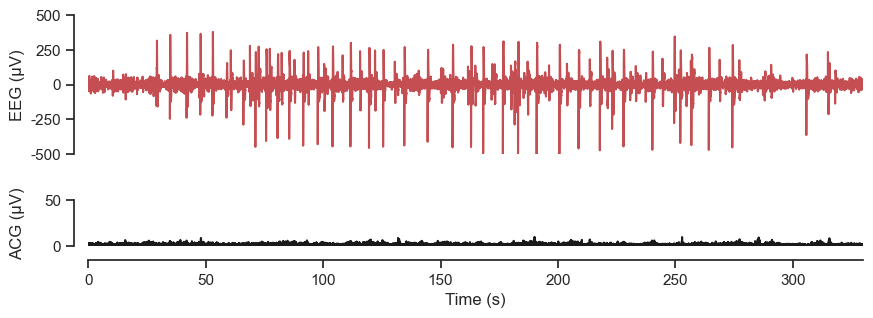

In [383]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(
    context='notebook',
    style='ticks',
    palette='deep',
    font='Arial',
    font_scale=1,
    color_codes=True,
    rc={'axes.unicode_minus': False}
)

fig, ax = plt.subplots(2, 1, figsize=(10, 3),
                       sharex='all', gridspec_kw={'hspace': .5, 'height_ratios': [3, 1]})

sns.lineplot(x=t, y=eeg, ax=ax[0], color='r')
sns.lineplot(x=t, y=acg, ax=ax[1], color='k')

ax[0].set(ylabel='EEG (μV)', ylim=(-500, 500))
ax[0].tick_params("x", length=0)
ax[1].set(ylabel='ACG (μV)', ylim=(0, 50))

plt.xlim(*t[[0, -1]])
plt.xlabel('Time (s)')

sns.despine(offset=10)
sns.despine(ax=ax[0], bottom=True)
fig.align_labels()
plt.show()

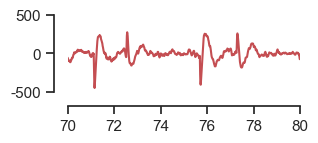

In [384]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1))

sns.lineplot(x=t, y=eeg, ax=ax, color='r')

ax.set(ylim=(-500, 500), xlim=(70, 80))
sns.despine(ax=ax, offset=10)


## 使用`find_peak()`对痫波进行统计

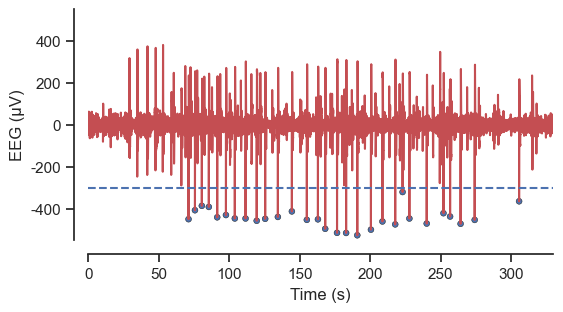

In [385]:
from scipy.signal import find_peaks

peaks, peak_values = find_peaks(-eeg, height=300, prominence=400, width=(0, 0.2 * sf))

sns.set_theme(
    context='notebook',
    style='ticks',
    palette='deep',
    font='Arial',
    font_scale=1,
    color_codes=True,
    rc={'axes.unicode_minus': False}
)

plt.figure(figsize=(6, 3))

sns.lineplot(x=t, y=eeg, color="r")
sns.scatterplot(x=peaks / raw.info['sfreq'], y=eeg[peaks], markers='o', size=3, edgecolor='k')
sns.lineplot(y=-300, x=raw.times[[0, -1]], linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('EEG (μV)')
plt.ylim(-550, 550)
plt.xlim(*t[[0, -1]])
sns.despine(offset=10)
plt.legend().remove()
plt.show()

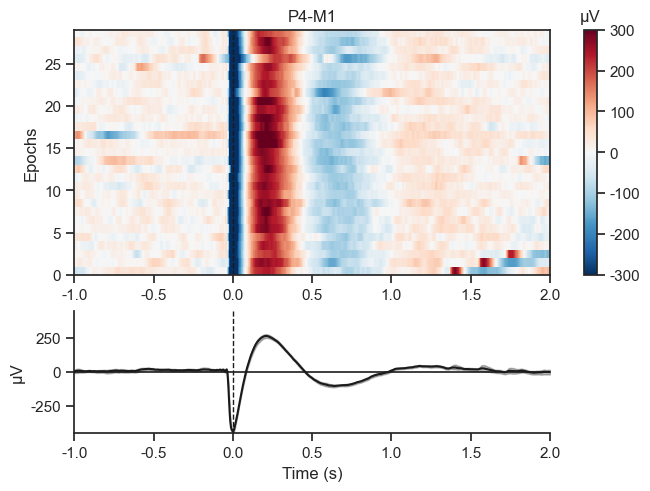

In [386]:
import numpy as np

onsets = peaks / sf
durations = np.zeros_like(peaks)
descriptions = ['spike'] * len(onsets)
annot_spike = mne.Annotations(
    onsets, durations, descriptions
)
raw.set_annotations(raw.annotations + annot_spike)

spike_events, event_id = mne.events_from_annotations(raw, event_id={'spike': 1})
epochs = mne.Epochs(raw, spike_events, tmin=-1, tmax=2, event_id=event_id, preload=True)
epochs.plot_image(picks=0, vmin=-300, vmax=300)
plt.show()

# 2. 成串慢波
另一个奇怪的波形是成串的高幅值慢波，类似于睡眠的N3期，但是从视频上看明显处于清醒。这在2024-05-14整个session期间都非常典型。

In [387]:
session = '2024-05-14'
raw = mne.io.read_raw_edf(os.path.join(dataset.path['tmp'], animal, session, 'raw.edf'), preload=True)
raw.notch_filter(50)
# raw.filter(0.1, 4, picks=[0])
raw.crop(37 * 60, 38 * 60)
t = raw.times
eeg = raw.get_data(picks=0, units='uV').squeeze()
acg = raw.get_data(picks=1, units='uV').squeeze()

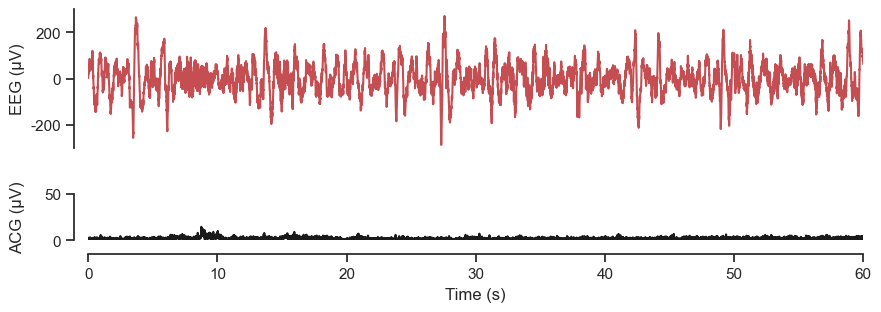

In [388]:
fig, ax = plt.subplots(2, 1, figsize=(10, 3),
                       sharex='all', gridspec_kw={'hspace': .5, 'height_ratios': [3, 1]})

sns.lineplot(x=t, y=eeg, ax=ax[0], color='r')
sns.lineplot(x=t, y=acg, ax=ax[1], color='k')

ax[0].set(ylabel='EEG (μV)', ylim=(-300, 300))
ax[0].tick_params("x", length=0)
ax[1].set(ylabel='ACG (μV)', ylim=(0, 50))

plt.xlim(*t[[0, -1]])
plt.xlabel('Time (s)')

sns.despine(offset=10)
sns.despine(ax=ax[0], bottom=True)
fig.align_labels()
plt.show()

## 使用`sw_detect()`对其检测

In [413]:
from yasa import sw_detect

sw = sw_detect(
    eeg, sf,
    freq_sw=(0.2, 1.5),
    dur_neg=(0.3, 3), dur_pos=(0.3, 3), amp_neg=(60, 300),
    amp_pos=(60, 500), amp_ptp=(100, 1000),
    remove_outliers=False, verbose=False
)

In [414]:
sw.summary()

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Channel,IdxChannel
0,1.552,1.828,2.040,2.240,2.436,0.884,-78.763474,73.354331,152.117805,717.536817,1.131222,CHAN000,0
1,3.116,3.340,3.528,3.748,3.964,0.848,-154.039883,198.498114,352.537997,1875.202113,1.179245,CHAN000,0
2,5.204,5.384,5.540,5.756,5.964,0.760,-71.551193,121.815156,193.366348,1239.527875,1.315789,CHAN000,0
3,13.036,13.288,13.496,13.732,13.960,0.924,-126.647492,154.382808,281.030300,1351.107211,1.082251,CHAN000,0
4,13.960,14.176,14.408,14.596,14.812,0.852,-128.351410,79.265913,207.617323,894.902252,1.173709,CHAN000,0
5,17.548,17.824,18.036,18.268,18.500,0.952,-70.358759,81.116270,151.475028,714.504851,1.050420,CHAN000,0
6,18.500,18.724,18.960,19.180,19.408,0.908,-71.032531,60.952841,131.985372,559.260050,1.101322,CHAN000,0
7,20.868,21.080,21.292,21.488,21.720,0.852,-109.598551,90.737915,200.336465,944.983326,1.173709,CHAN000,0
8,24.380,24.592,24.808,24.988,25.232,0.852,-124.338010,78.654599,202.992608,939.780594,1.173709,CHAN000,0
9,25.656,25.900,26.088,26.292,26.504,0.848,-89.740141,104.784453,194.524594,1034.705289,1.179245,CHAN000,0


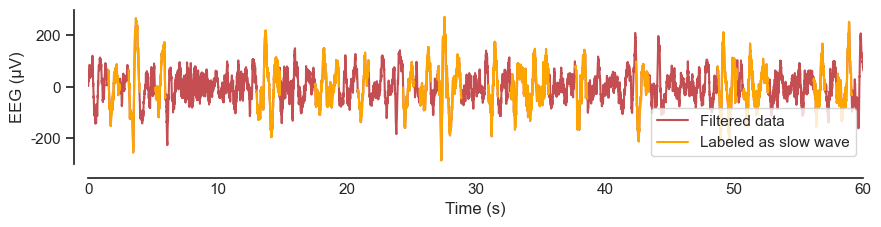

In [416]:
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10, 2))

eeg_sw = eeg.copy()
eeg_sw[sw.get_mask() != 1] = np.nan
l1 = sns.lineplot(x=t, y=eeg, ax=ax, color='r', label='Filtered data')
l2 = ax.plot(t, eeg_sw, color='orange', label='Labeled as slow wave')

ax.set(ylabel='EEG (μV)', ylim=(-300, 300))
ax.tick_params("x", length=0)

plt.xlim(*t[[0, -1]])
plt.xlabel('Time (s)')

sns.despine(offset=10)
plt.legend()
fig.align_labels()
plt.show()

# 3. 对所有session进行检查 

## 先对所有的session制表

In [455]:
import pandas as pd
import glob

files = glob.glob(os.path.join(dataset.path['tmp'], '**', 'raw.edf'), recursive=True)
df_info = dataset.load_info()
df_sessions = pd.DataFrame()

for file in files:
    animal, session = np.array(file.split('\\'))[[-3, -2]]
    group = df_info.loc[animal, 'Genotype']

    fname = os.path.join(dataset.path['tmp'], animal, session, 'raw.edf')
    raw = mne.io.read_raw_edf(fname)

    # session table
    session_length = raw.times[-1]
    df_sessions_tmp = pd.DataFrame({
        'animal_id': animal,
        'genotype': group,
        'session': session,
        'session_length': session_length
    }, index=[0])
    df_sessions = pd.concat([df_sessions, df_sessions_tmp])

df_sessions = df_sessions.reset_index(drop=True)
pd.concat([df_sessions.head(2), df_sessions.tail(2)])

,animal_id,genotype,session,session_length
0,0628#,WT,2024-03-14,2481.996
1,0628#,WT,2024-04-07,4215.996
56,0800#,Mutant,2024-05-14,6162.996
57,0805#,Mutant,2024-03-31,4066.996


## 定义伪迹标准并标注

In [63]:
def find_over_thr_segs(data, thr, pad=0):
    def _find_terminals(bi_data):
        bi_data[0] = 0
        bi_data[-1] = 0
        bi_bad = np.diff(bi_data)
        bad_start_idx = np.argwhere(bi_bad == 1).reshape(-1)
        bad_end_idx = np.argwhere(bi_bad == -1).reshape(-1) + 1

        return bad_start_idx, bad_end_idx

    flag = np.abs(data) > thr * np.ones(shape=data.shape)
    bi = np.zeros(shape=data.shape)
    bi[flag] = 1

    start_idx, end_idx = _find_terminals(bi)

    if pad > 0:
        start_idx = start_idx - pad
        end_idx = end_idx + pad

        start_idx[start_idx < 0] = 0
        end_idx[end_idx > data.size] = data.size

        bi = np.zeros(shape=data.shape)
        for (start_idx, end_idx) in zip(start_idx, end_idx):
            bi[int(start_idx):int(end_idx)] = 1
            start_idx, end_idx = _find_terminals(bi)

    return start_idx, end_idx, bi

In [64]:
def art_annot(raw):
    sf = raw.info['sfreq']

    # muscle activity
    annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
        raw,
        ch_type='eeg',
        threshold=2,
        min_length_good=0.5,
        filter_freq=[110, 120],
    )

    min_dur_muscle = 0.5  # seconds
    annot_muscle = annot_muscle[annot_muscle.duration > min_dur_muscle]

    # acg
    acg = raw.get_data(picks=1, units='uV').squeeze()
    bad_start_idx, bad_end_idx, bi_bad = find_over_thr_segs(acg, thr=20, pad=sf * 2)

    onsets = bad_start_idx / sf
    durations = (bad_end_idx - bad_start_idx) / sf
    descriptions = ['BAD_loco'] * len(bad_start_idx)
    annot_loco = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )

    # eeg
    eeg = raw.get_data(picks=0, units='uV').squeeze()
    bad_start_idx, bad_end_idx, bi_bad = find_over_thr_segs(eeg, thr=1200, pad=sf * 2)

    onsets = bad_start_idx / sf
    durations = (bad_end_idx - bad_start_idx) / sf
    descriptions = ['BAD_eeg'] * len(bad_start_idx)
    annot_eeg = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )

    raw.set_annotations(raw.annotations + annot_loco + annot_muscle + annot_eeg)

    return raw

In [65]:
def annot_to_mask(raw):
    sf = raw.info['sfreq']
    start_idx = (raw.annotations.onset * sf).astype('int')
    end_idx = ((raw.annotations.onset + raw.annotations.duration) * sf).astype('int')
    flag_ignore = np.zeros_like(raw.times, dtype='bool')
    for (si, ei) in zip(start_idx, end_idx):
        flag_ignore[si:ei + 1] = True

    return flag_ignore

In [66]:
def spike_annot(raw, bad_mask):
    sf = raw.info['sfreq']

    # spike
    data = raw.copy().filter(0.1, 30).get_data(picks=0, units='uV').squeeze()
    data[bad_mask] = np.nan
    peaks, properties = find_peaks(-data, height=200, prominence=300, distance=0.5 * sf, width=(0, 0.2 * sf))

    onsets = peaks / sf
    durations = np.zeros_like(peaks)
    descriptions = ['spike'] * len(onsets)
    annot_spike = mne.Annotations(
        onsets, durations, descriptions, orig_time=raw.info["meas_date"]
    )
    raw.set_annotations(raw.annotations + annot_spike)

    return raw, peaks, properties

In [67]:
animals = df_sessions['animal_id'].unique()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()
    genotype = df_sessions.query('animal_id == @animal')['genotype'].iloc[0]

    for session in sessions:
        fname = os.path.join(dataset.path['tmp'], animal, session, 'raw.edf')
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)

        raw.set_channel_types({'Loco': 'bio'})
        raw.notch_filter(50)

        raw = art_annot(raw)
        raw.export(raw.filenames[0].replace('.edf', '_art_annot.edf'), overwrite=True)


## Good sessions

In [456]:
df_sessions.insert(df_sessions.shape[1], 'session_length_bad', 0)

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()

    for session in sessions:
        
        fname = os.path.join(dataset.path['tmp'], animal, session, 'raw_art_annot.edf')
        raw = mne.io.read_raw_edf(fname, verbose=False)
        
        bad_mask = annot_to_mask(raw)
        df_sessions.loc[df_sessions.query("animal_id == @animal and session == @session").index, 'session_length_bad'] = bad_mask.sum() / sf 
            
        
df_sessions['session_length_good'] = df_sessions['session_length'] - df_sessions['session_length_bad']
df_sessions = df_sessions.drop('session_length_bad', axis=1)

C:\Users\60978\AppData\Local\Temp\ipykernel_45568\3847770030.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1658.476' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sessions.loc[df_sessions.query("animal_id == @animal and session == @session").index, 'session_length_bad'] = bad_mask.sum() / sf


In [362]:
df_sessions

,animal_id,genotype,session,session_length,session_length_good
0,0628#,WT,2024-03-14,2481.996,823.520
1,0628#,WT,2024-04-07,4215.996,2199.248
2,0628#,WT,2024-05-27,7975.996,4032.156
3,0629#,Mutant,2024-03-09,2006.996,896.656
4,0629#,Mutant,2024-03-29,3633.996,2338.972
5,0629#,Mutant,2024-04-22,3440.996,2238.540
6,0629#,Mutant,2024-05-15,7097.996,4453.688
7,0629#,Mutant,2024-05-29,5288.996,3414.144
8,0633#,WT,2024-03-09,2372.996,1626.696
9,0633#,WT,2024-03-28,3490.996,1985.068


## 对spike 发作期进行检测

### 检测spike

In [68]:
df_peak_property = pd.DataFrame()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()
    genotype = df_sessions.query('animal_id == @animal')['genotype'].iloc[0]

    for session in sessions:

        session_length = df_sessions.query('animal_id == @animal and session==@session')['session_length'].iloc[0]

        fname = os.path.join(dataset.path['tmp'], animal, session, 'raw_art_annot.edf')
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)

        bad_mask = annot_to_mask(raw)
        raw, peaks, properties = spike_annot(raw, bad_mask)

        raw.export(raw.filenames[0].replace('.edf', '_spike_detect.edf'), overwrite=True)

        # spike table
        if peaks.size > 0:
            spike_events, event_id = mne.events_from_annotations(raw, event_id={'spike': 1})
            if spike_events.size > 0:
                epochs = mne.Epochs(raw, spike_events, tmin=-1, tmax=1, event_id=event_id, preload=True)
                if len(epochs) > 0:
                    peak_onset = epochs.events[:, 0]
                    isi = np.zeros_like(peak_onset)
                    isi[1:] = np.diff(peak_onset)

                    df_peak_property_tmp = pd.DataFrame(properties).loc[epochs.selection, :]
                    df_peak_property_tmp.insert(0, 'isi', isi)
                    df_peak_property_tmp.insert(0, 'peak_onset', peak_onset)
                    df_peak_property_tmp.insert(0, 'session_length', session_length)
                    df_peak_property_tmp.insert(0, 'genotype', genotype)
                    df_peak_property_tmp.insert(0, 'session', session)
                    df_peak_property_tmp.insert(0, 'animal_id', animal)

                    df_peak_property = pd.concat([df_peak_property, df_peak_property_tmp])



### 根据spike rate定义发作期

In [69]:
def hist_bin(timestamp, bin_width=10, bin_step=5, max_len=None):
    if max_len is None:
        max_len = (timestamp.max() // bin_width) * (bin_width + 1)

    start = 0
    count = []
    start_points = []
    while start < max_len:
        end = start + bin_width
        count.append(((timestamp < end) & (timestamp >= start)).sum())
        start_points.append(start)
        start += bin_step

    return np.array(count) / bin_width, np.array(start_points)

In [70]:
thr_sr = 0.1
bin_width = 30

df_epi_period = pd.DataFrame()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()

    for session in sessions:

        df_spike_session = df_peak_property.query('animal_id == @animal and session == @session')
        df_spike_session = df_spike_session.query('isi / @sf < 10 and isi / @sf > 0')
        df_spike_session = df_spike_session.reset_index(drop=True)

        if len(df_spike_session) > 0:
            session_length = df_spike_session.loc[0, 'session_length']

            sr, bin_edges = hist_bin(df_spike_session['peak_onset'] / sf, bin_width=bin_width, bin_step=1,
                                     max_len=session_length)

            onsets, offsets, _ = find_over_thr_segs(sr, thr_sr)
            if len(onsets) > 0:
                # spike rate in onset period
                sr_period = []
                for (on, off) in zip(onsets, offsets):
                    sr_period.append(
                        ((df_spike_session['peak_onset'] / sf < off) & (
                                df_spike_session['peak_onset'] / sf >= on)).sum() / (
                                off - on))

                # make table of onset period
                df_epi_period_tmp = pd.DataFrame({'onsets': onsets, 'offsets': offsets, 'duration': offsets - onsets})
                df_epi_period_tmp = pd.concat(
                    [pd.concat(
                        [df_sessions.query('animal_id == @animal and session == @session')] * len(df_epi_period_tmp),
                        ignore_index=True), df_epi_period_tmp],
                    axis=1
                )

                df_epi_period_tmp['spike_rate'] = np.array(sr_period)
                df_epi_period = pd.concat([df_epi_period, df_epi_period_tmp])

df_epi_period = df_epi_period.reset_index(drop=True)


In [71]:
df_epi_period

,animal_id,genotype,session,session_length,onsets,offsets,duration,spike_rate
0,0629#,Mutant,2024-03-09,2006.996,1936,1956,20,0.100000
1,0767#,Mutant,2024-04-26,5142.996,1465,1479,14,0.142857
2,0800#,Mutant,2024-04-18,3443.996,2240,2294,54,0.148148
3,0800#,Mutant,2024-04-18,3443.996,2294,2302,8,0.125000
4,0800#,Mutant,2024-04-18,3443.996,2304,2310,6,0.166667
5,0800#,Mutant,2024-04-18,3443.996,2341,2373,32,0.156250
6,0800#,Mutant,2024-04-18,3443.996,2377,2381,4,0.250000
7,0800#,Mutant,2024-04-18,3443.996,2383,2399,16,0.125000
8,0800#,Mutant,2024-05-14,6162.996,996,1007,11,0.090909


In [72]:
i = 0
while i < len(df_epi_period) - 1:
    if (
            (df_epi_period.loc[i + 1, 'onsets'] - df_epi_period.loc[i, 'offsets'] <= bin_width) and
            (df_epi_period.loc[i + 1, 'animal_id'] == df_epi_period.loc[i, 'animal_id']) and
            (df_epi_period.loc[i + 1, 'session'] == df_epi_period.loc[i, 'session'])
    ):
        spike_counts = (
                df_epi_period.loc[i + 1, 'spike_rate'] * df_epi_period.loc[i + 1, 'duration'] +
                df_epi_period.loc[i, 'spike_rate'] * df_epi_period.loc[i, 'duration']
        )

        df_epi_period.loc[i, 'offsets'] = df_epi_period.loc[i + 1, 'offsets']
        df_epi_period.loc[i, 'duration'] = df_epi_period.loc[i, 'offsets'] - df_epi_period.loc[i, 'onsets']
        df_epi_period.loc[i, 'spike_rate'] = spike_counts / df_epi_period.loc[i, 'duration']
        df_epi_period = df_epi_period.drop(i + 1)
        df_epi_period = df_epi_period.reset_index(drop=True)

    else:
        i += 1

df_epi_period = df_epi_period.query('duration >= @ bin_width')
df_epi_period = df_epi_period.reset_index(drop=True)
df_epi_period.to_excel(os.path.join(dataset.path['results'], 'epi_period.xlsx'))

## 对sequential slow wave发作期进行检测

In [457]:
def fract_bin(mask, sf, bin_width=10, bin_step=5, max_len=None):
    if max_len is None:
        max_len = (mask.size / sf // bin_width) * (bin_width + 1)

    start = 0
    frac = []
    start_points = []
    while start < max_len:
        end = start + bin_width
        frac.append(
            (mask[int(start * sf):int(end * sf) + 1] == 1).sum() /
            (~np.isnan(mask[int(start * sf):int(end * sf) + 1])).sum()
        )
        start_points.append(start)
        start += bin_step

    return np.array(frac), np.array(start_points)

In [458]:
thr_sswr = 0.2
bin_width = 30

df_ssw_period = pd.DataFrame()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()

    for session in sessions:
        
        session_length = df_sessions.query('animal_id == @animal and session==@session')['session_length'].iloc[0]
        
        fname = os.path.join(dataset.path['tmp'], animal, session, 'raw_art_annot.edf')
        raw = mne.io.read_raw_edf(fname, preload=True, verbose=False)
        
        bad_mask = annot_to_mask(raw)
        
        sw = sw_detect(
            raw.get_data(picks=0, units='uV').squeeze(), 
            sf,
            freq_sw=(0.2, 1.5),
            dur_neg=(0.3, 3), dur_pos=(0.3, 3), amp_neg=(60, 300),
            amp_pos=(60, 500), amp_ptp=(100, 1000),
            remove_outliers=False, verbose=False
        )
        
        if sw:
            sw_mask = sw.get_mask()
            
            sw_mask = sw_mask.astype('float')
            sw_mask[bad_mask] = np.nan
                        
            frac, _ = fract_bin(sw_mask, sf, bin_width=bin_width, bin_step=1, max_len=session_length)
            
            onsets, offsets, _ = find_over_thr_segs(frac, thr_sswr)
            if len(onsets) > 0:
                # sw fraction in onset period
                sw_frac = []
                for (on, off) in zip(onsets, offsets):
                    sw_frac.append(
                        (sw_mask[int(on*sf):int(off*sf+1)] == 1).sum() /
                        (~np.isnan(sw_mask[int(on*sf):int(off*sf+1)])).sum()
                    )
    
                # make table of onset period
                df_ssw_period_tmp = pd.DataFrame({'onsets': onsets, 'offsets': offsets, 'duration': offsets - onsets})
                df_ssw_period_tmp = pd.concat(
                    [pd.concat(
                        [df_sessions.query('animal_id == @animal and session == @session')] * len(df_ssw_period_tmp),
                        ignore_index=True), df_ssw_period_tmp],
                    axis=1
                )
    
                df_ssw_period_tmp['slow_wave_fraction'] = np.array(sw_frac)
                df_ssw_period = pd.concat([df_ssw_period, df_ssw_period_tmp])

df_ssw_period = df_ssw_period.reset_index(drop=True)


C:\Users\60978\AppData\Local\Temp\ipykernel_45568\2998337816.py:11: RuntimeWarning: invalid value encountered in scalar divide
  (mask[int(start * sf):int(end * sf) + 1] == 1).sum() /
C:\Users\60978\AppData\Local\Temp\ipykernel_45568\2998337816.py:11: RuntimeWarning: invalid value encountered in scalar divide
  (mask[int(start * sf):int(end * sf) + 1] == 1).sum() /
C:\Users\60978\AppData\Local\Temp\ipykernel_45568\2998337816.py:11: RuntimeWarning: invalid value encountered in scalar divide
  (mask[int(start * sf):int(end * sf) + 1] == 1).sum() /
C:\Users\60978\AppData\Local\Temp\ipykernel_45568\2998337816.py:11: RuntimeWarning: invalid value encountered in scalar divide
  (mask[int(start * sf):int(end * sf) + 1] == 1).sum() /
C:\Users\60978\AppData\Local\Temp\ipykernel_45568\3066092261.py:41: RuntimeWarning: invalid value encountered in scalar divide
  (sw_mask[int(on*sf):int(off*sf+1)] == 1).sum() /
C:\Users\60978\AppData\Local\Temp\ipykernel_45568\3066092261.py:41: RuntimeWarning: in

## 对session进行统计

In [459]:
df_sessions.insert(df_sessions.shape[1], 'spike_rate', 0)
df_sessions.insert(df_sessions.shape[1], 'slow_wave_fraction', 0)

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()

    for session in sessions:
        
        # spike rate
        df_epi_period_session = df_epi_period.query("animal_id == @animal and session == @session")
        if len(df_epi_period_session) == 0:
            spike_rate_session = 0
        else:
            spike_rate_session = (
                    (df_epi_period_session['spike_rate'] * df_epi_period_session['duration']).sum() /
                    df_epi_period_session['duration'].sum()
            )

        df_sessions.loc[
            df_sessions.query("animal_id == @animal and session == @session").index, 'spike_rate'] = spike_rate_session
        
        # slow wave fraction
        df_ssw_period_session = df_ssw_period.query("animal_id == @animal and session == @session")
        if len(df_ssw_period_session) == 0:
            ssw_session = 0
        else:
            ssw_session = (
                    (df_ssw_period_session['slow_wave_fraction'] * df_ssw_period_session['duration']).sum() /
                    df_ssw_period_session['session_length'].unique()[0]
            )

        df_sessions.loc[
            df_sessions.query("animal_id == @animal and session == @session").index, 'slow_wave_fraction'] = ssw_session
        
        

C:\Users\60978\AppData\Local\Temp\ipykernel_45568\3867358092.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00019145957614589938' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sessions.loc[
C:\Users\60978\AppData\Local\Temp\ipykernel_45568\3867358092.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.140625' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sessions.loc[


In [460]:
df_sessions

,animal_id,genotype,session,session_length,session_length_good,spike_rate,slow_wave_fraction
0,0628#,WT,2024-03-14,2481.996,823.520,0.000000,0.000000
1,0628#,WT,2024-04-07,4215.996,2199.248,0.000000,0.000191
2,0628#,WT,2024-05-27,7975.996,4032.156,0.000000,0.000000
3,0629#,Mutant,2024-03-09,2006.996,896.656,0.000000,0.140371
4,0629#,Mutant,2024-03-29,3633.996,2338.972,0.000000,0.004849
5,0629#,Mutant,2024-04-22,3440.996,2238.540,0.000000,0.000000
6,0629#,Mutant,2024-05-15,7097.996,4453.688,0.000000,0.000000
7,0629#,Mutant,2024-05-29,5288.996,3414.144,0.000000,0.002274
8,0633#,WT,2024-03-09,2372.996,1626.696,0.000000,0.000000
9,0633#,WT,2024-03-28,3490.996,1985.068,0.000000,0.000000


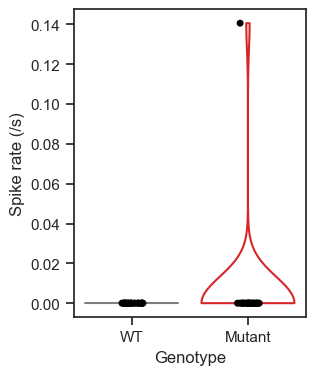

In [461]:
import seaborn as sns

plt.figure(figsize=(3, 4))
sns.violinplot(
    data=df_sessions,
    x='genotype',
    y='spike_rate',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['tab:gray', 'tab:red'],
    cut=0,
    fill=False
)

sns.stripplot(
    data=df_sessions,
    x='genotype',
    y='spike_rate',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['black', 'black']
)
plt.xlabel('Genotype')
plt.ylabel('Spike rate (/s)')
plt.show()

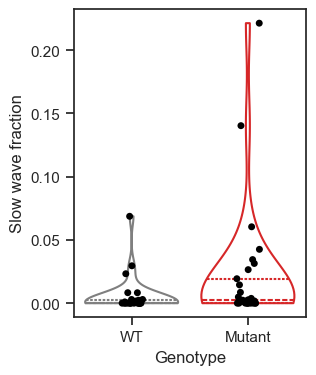

In [462]:
import seaborn as sns

plt.figure(figsize=(3, 4))
sns.violinplot(
    data=df_sessions,
    x='genotype',
    y='slow_wave_fraction',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['tab:gray', 'tab:red'],
    cut=0,
    fill=False,
    inner='quart'
)

sns.stripplot(
    data=df_sessions,
    x='genotype',
    y='slow_wave_fraction',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['black', 'black']
)
plt.xlabel('Genotype')
plt.ylabel('Slow wave fraction')
plt.show()

In [463]:
from scipy.stats import levene, ttest_ind, ranksums

group_A = df_sessions.loc[df_sessions['genotype'] == 'WT', 'slow_wave_fraction']
group_B = df_sessions.loc[df_sessions['genotype'] == 'Mutant', 'slow_wave_fraction']
stat, p = ranksums(group_A, group_B)
print(f'P value: {p:.2f}')

P value: 0.08


## 发作期频域性质

In [464]:
df_sessions.insert(df_sessions.shape[1], 'if_onset', 'rest')
df_sessions.loc[df_sessions.query("spike_rate > 0 or slow_wave_fraction > 0").index, 'if_onset'] = 'onset'

In [465]:
df_sessions

,animal_id,genotype,session,session_length,session_length_good,spike_rate,slow_wave_fraction,if_onset
0,0628#,WT,2024-03-14,2481.996,823.520,0.000000,0.000000,rest
1,0628#,WT,2024-04-07,4215.996,2199.248,0.000000,0.000191,onset
2,0628#,WT,2024-05-27,7975.996,4032.156,0.000000,0.000000,rest
3,0629#,Mutant,2024-03-09,2006.996,896.656,0.000000,0.140371,onset
4,0629#,Mutant,2024-03-29,3633.996,2338.972,0.000000,0.004849,onset
5,0629#,Mutant,2024-04-22,3440.996,2238.540,0.000000,0.000000,rest
6,0629#,Mutant,2024-05-15,7097.996,4453.688,0.000000,0.000000,rest
7,0629#,Mutant,2024-05-29,5288.996,3414.144,0.000000,0.002274,onset
8,0633#,WT,2024-03-09,2372.996,1626.696,0.000000,0.000000,rest
9,0633#,WT,2024-03-28,3490.996,1985.068,0.000000,0.000000,rest


In [466]:
df_psd = pd.DataFrame()
for i, row in df_sessions.iterrows():
    animal = row['animal_id']
    session = row['session']
    genotype = row['genotype']
    if_onset = row['if_onset']
    
    fname = os.path.join(dataset.path['tmp'], animal, session, 'raw_art_annot.edf')
    raw = mne.io.read_raw_edf(fname, preload=True)
    sf = raw.info['sfreq']

    # drop bad epochs
    seg_duration = 2  # seconds
    n_seg = raw.times.shape[0] // (sf * seg_duration)  # assert number of seg more than time
    raw.crop(0, seg_duration * n_seg, include_tmax=False)
    raw.set_channel_types({'Loco': 'bio'})    
    
    epochs = mne.make_fixed_length_epochs(raw.copy(), duration=seg_duration, preload=True)
    epochs.drop_bad(flat=dict(eeg=5e-6))
    # epochs.plot_drop_log()
    
    # concatenate data
    raw_clean = raw.copy()
    raw_clean.filter(0.1, 40)
    data = raw_clean.get_data()
    data = data.reshape(2, len(epochs.drop_log), -1)
    flag = np.ones(len(epochs.drop_log), dtype='bool')
    flag[epochs.selection] = False
    data[0, flag, :] = np.nan
    data = data.reshape(2, -1)
    
    raw_clean._data = data * 1e6    
    raw_clean = raw_clean.pick([raw.ch_names[0]])
    psd = raw_clean.compute_psd(fmax=40, method='welch', n_fft=1000, n_overlap=100, n_per_seg=500)
    df = psd.to_data_frame()

        
    df['genotype'] = genotype
    df['if_onset'] = if_onset
        
    df_psd = pd.concat([df_psd, df], ignore_index=True)  
        
    

In [467]:
df_psd

,freq,P4-M1,genotype,if_onset
0,0.00,7.019564,WT,rest
1,0.25,21.694395,WT,rest
2,0.50,50.643195,WT,rest
3,0.75,111.347121,WT,rest
4,1.00,179.670511,WT,rest
...,...,...,...,...
9333,39.00,1.578468,Mutant,rest
9334,39.25,1.575583,Mutant,rest
9335,39.50,1.559835,Mutant,rest
9336,39.75,1.585428,Mutant,rest


In [468]:
eeg_ch_name = raw.ch_names[0]
df_psd[eeg_ch_name] = 10 * np.log10(df_psd[eeg_ch_name])

In [469]:
from scipy.stats import ttest_ind, levene
from statsmodels.stats.multitest import fdrcorrection

pvalues = np.zeros(psd.freqs.shape[0])
for i, freq in enumerate(psd.freqs):
    A = df_psd.loc[df_psd.query("freq == @freq and genotype == 'WT'").index, eeg_ch_name]
    B = df_psd.loc[df_psd.query("freq == @freq and genotype == 'Mutant' and if_onset == 'onset'").index, eeg_ch_name]
    
    _, p_square = levene(A, B)
    res = ttest_ind(A, B, equal_var=p_square > 0.05)
    pvalues[i] = res.pvalue
    
rejected, pvalues_fdr = fdrcorrection(pvalues) 

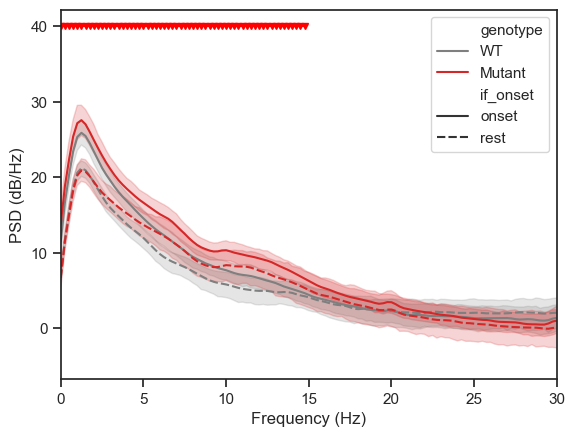

In [470]:
import seaborn as sns

sns.set_context('notebook')
sns.lineplot(
    x="freq",
    y=eeg_ch_name,
    hue="genotype",
    hue_order=['WT','Mutant'],
    palette=['tab:gray', 'tab:red'],
    style='if_onset',
    style_order=['onset', 'rest'],
    data=df_psd
)
pvalues_plot = np.zeros(psd.freqs.shape[0])
pvalues_plot[:] = np.nan
pvalues_plot[pvalues_fdr < 0.05] = 40
plt.plot(psd.freqs, pvalues_plot, 'red', marker='v', markersize=5)
plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 30])
plt.legend(title=None)
plt.show()